In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

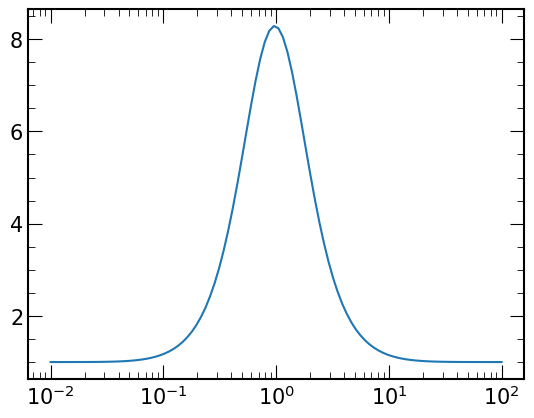

In [3]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-4-35145dc20a06>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
11.4882972240448
4.5 0.1
finished until t = 0.0 1.3986215591430664
finished until t = 0.5 7.938735723495483


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 1.0 18.402602434158325
finished until t = 1.5 33.304436922073364
finished until t = 2.0 50.73207449913025
finished until t = 2.5 70.8189046382904
finished until t = 3.0 94.0864326953888
finished until t = 3.5 119.414626121521
finished until t = 4.0 146.5899395942688
finished until t = 4.5 176.04949688911438
finished until t = 5.0 206.08191990852356
finished until t = 5.5 237.3789029121399
finished until t = 6.0 270.5415916442871
finished until t = 6.5 306.7166314125061
finished until t = 7.0 345.7012050151825
finished until t = 7.5 386.89458751678467
finished until t = 8.0 429.7722427845001
finished until t = 8.5 474.37569522857666
finished until t = 9.0 520.5043323040009
finished until t = 9.5 567.9431946277618
finished until t = 10.0 617.5294904708862


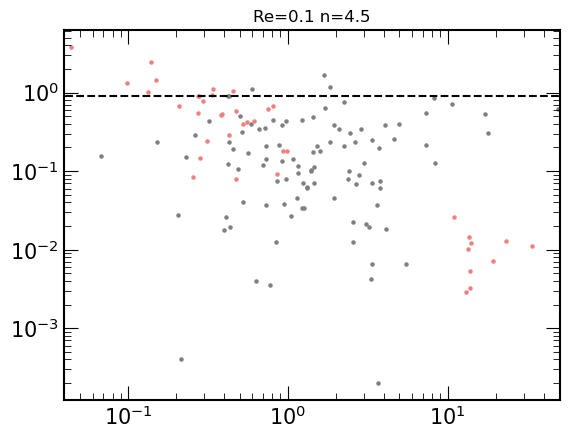

Calculating NFW Energies and Weights


<ipython-input-4-35145dc20a06>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
6.874885082244873
4.5 0.6
finished until t = 0.0 0.7717514038085938
finished until t = 0.5 5.711820840835571
finished until t = 1.0 15.737526178359985
finished until t = 1.5 30.236897230148315
finished until t = 2.0 51.30375957489014
finished until t = 2.5 77.40258145332336
finished until t = 3.0 111.30713224411011
finished until t = 3.5 151.87542247772217
finished until t = 4.0 198.10409235954285
finished until t = 4.5 250.13116931915283
finished until t = 5.0 307.1854181289673
finished until t = 5.5 369.61437368392944
finished until t = 6.0 437.229035615921
finished until t = 6.5 510.3919768333435
finished until t = 7.0 588.5172057151794
finished until t = 7.5 672.2366271018982
finished until t = 8.0 760.7797796726227
finished until t = 8.5 854.0231029987335
finished until t = 9.0 952.4256517887115
finished until t = 9.5 1055.6272575855255
finished until t = 10.0 1163.1112880706787


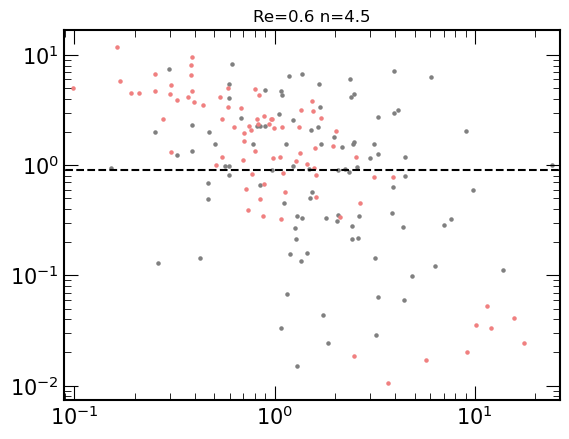

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.047127485275269
4.5 1.1
finished until t = 0.0 0.8632996082305908
finished until t = 0.5 6.905287265777588
finished until t = 1.0 18.29034972190857
finished until t = 1.5 34.785996198654175
finished until t = 2.0 56.78136706352234
finished until t = 2.5 84.1822497844696
finished until t = 3.0 116.77103614807129
finished until t = 3.5 154.99671721458435
finished until t = 4.0 198.40603160858154
finished until t = 4.5 247.8988742828369
finished until t = 5.0 303.1529200077057
finished until t = 5.5 364.4566376209259
finished until t = 6.0 431.3827006816864
finished until t = 6.5 504.41238617897034
finished until t = 7.0 582.860006570816
finished until t = 7.5 666.9750685691833
finished until t = 8.0 756.2846784591675
finished until t = 8.5 851.2060589790344
finished until t = 9.0 951.3905906677246
finished until t = 9.5 1056.4592072963715
finished until t = 10.0 1167.18927693367


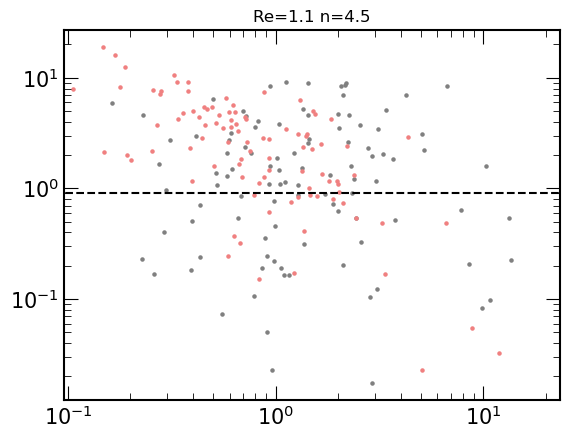

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.074392080307007
4.5 1.6
finished until t = 0.0 0.7137250900268555
finished until t = 0.5 5.775016784667969
finished until t = 1.0 14.975810289382935
finished until t = 1.5 28.30064868927002
finished until t = 2.0 46.31220817565918
finished until t = 2.5 68.51659798622131
finished until t = 3.0 95.32364225387573
finished until t = 3.5 126.81311893463135
finished until t = 4.0 162.1094274520874
finished until t = 4.5 202.51450300216675
finished until t = 5.0 247.0797426700592
finished until t = 5.5 296.10167837142944
finished until t = 6.0 349.73042583465576
finished until t = 6.5 407.87942361831665
finished until t = 7.0 470.01581716537476
finished until t = 7.5 536.8175551891327
finished until t = 8.0 608.2920875549316
finished until t = 8.5 684.1859345436096
finished until t = 9.0 764.9868421554565
finished until t = 9.5 850.0993945598602
finished until t = 10.0 939.917667388916


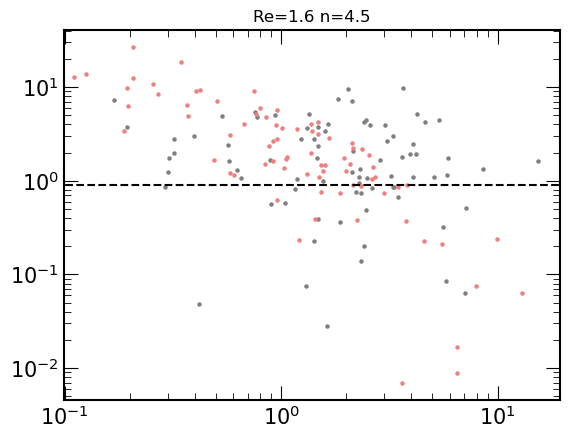

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.285017251968384
4.5 2.1
finished until t = 0.0 0.8100852966308594
finished until t = 0.5 6.840386390686035
finished until t = 1.0 18.209757566452026
finished until t = 1.5 34.92534303665161
finished until t = 2.0 57.04071116447449
finished until t = 2.5 84.70603132247925
finished until t = 3.0 117.62748837471008
finished until t = 3.5 156.29153084754944
finished until t = 4.0 200.5098090171814
finished until t = 4.5 250.79301977157593
finished until t = 5.0 306.81555676460266
finished until t = 5.5 367.82463550567627
finished until t = 6.0 435.4243838787079
finished until t = 6.5 507.9948341846466
finished until t = 7.0 586.9142537117004
finished until t = 7.5 671.4391438961029
finished until t = 8.0 761.8060822486877
finished until t = 8.5 857.9460783004761
finished until t = 9.0 959.5945410728455
finished until t = 9.5 1066.4458539485931
finished until t = 10.0 1179.1323103904724


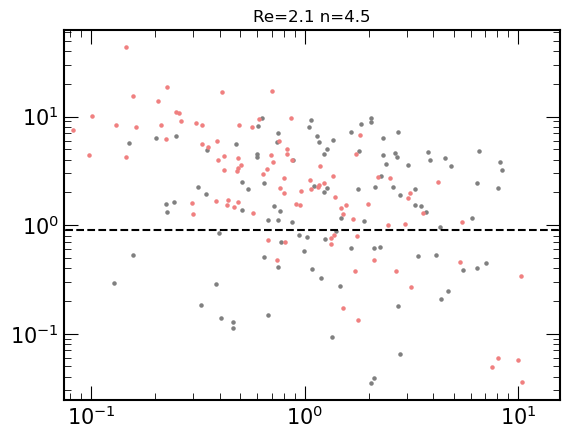

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.943294048309326
4.5 2.6
finished until t = 0.0 0.8807029724121094
finished until t = 0.5 7.491719722747803
finished until t = 1.0 19.513358116149902
finished until t = 1.5 37.40450882911682
finished until t = 2.0 60.785805225372314
finished until t = 2.5 90.47350406646729
finished until t = 3.0 125.90326118469238
finished until t = 3.5 166.80377078056335
finished until t = 4.0 213.98700976371765
finished until t = 4.5 267.75987219810486
finished until t = 5.0 328.28479170799255
finished until t = 5.5 394.5645098686218
finished until t = 6.0 466.998459815979
finished until t = 6.5 545.1555848121643
finished until t = 7.0 629.7904987335205
finished until t = 7.5 720.5019583702087
finished until t = 8.0 817.0753655433655
finished until t = 8.5 919.6692593097687
finished until t = 9.0 1022.7041504383087
finished until t = 9.5 1126.6701221466064
finished until t = 10.0 1236.778736591339


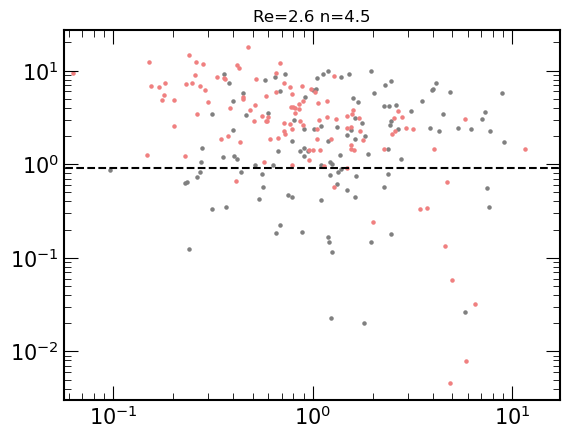

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.382290124893188
4.5 3.1
finished until t = 0.0 0.8172376155853271
finished until t = 0.5 6.001930236816406
finished until t = 1.0 16.031060457229614
finished until t = 1.5 30.135730981826782
finished until t = 2.0 48.918041467666626
finished until t = 2.5 72.03091025352478
finished until t = 3.0 99.6128261089325
finished until t = 3.5 131.72359776496887
finished until t = 4.0 168.60110330581665
finished until t = 4.5 210.11407804489136
finished until t = 5.0 255.81823635101318
finished until t = 5.5 306.2283203601837
finished until t = 6.0 361.1106185913086
finished until t = 6.5 420.83132767677307
finished until t = 7.0 484.62269353866577
finished until t = 7.5 553.0959694385529
finished until t = 8.0 626.0197749137878
finished until t = 8.5 698.6185085773468
finished until t = 9.0 772.6326951980591
finished until t = 9.5 851.0277945995331
finished until t = 10.0 933.6475698947906


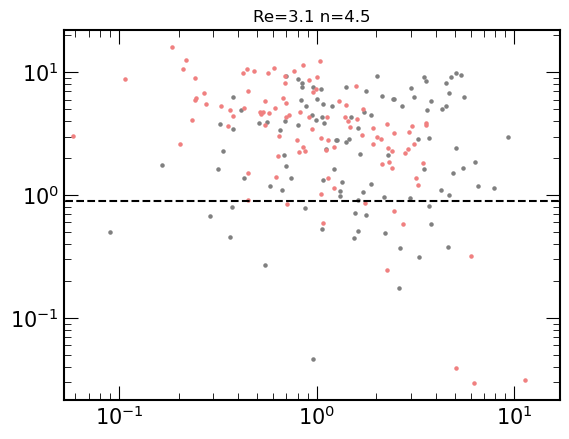

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.688059568405151
4.5 3.6
finished until t = 0.0 0.6850082874298096
finished until t = 0.5 4.7607972621917725
finished until t = 1.0 11.98061227798462
finished until t = 1.5 22.752212285995483
finished until t = 2.0 36.788898944854736
finished until t = 2.5 54.18146014213562
finished until t = 3.0 75.26254963874817
finished until t = 3.5 99.51309180259705
finished until t = 4.0 126.68474245071411
finished until t = 4.5 157.57366061210632
finished until t = 5.0 191.65098881721497
finished until t = 5.5 227.20741057395935
finished until t = 6.0 265.95783162117004
finished until t = 6.5 307.9129538536072
finished until t = 7.0 353.09554529190063
finished until t = 7.5 401.4275059700012
finished until t = 8.0 452.80483174324036
finished until t = 8.5 507.4637770652771
finished until t = 9.0 565.4182138442993
finished until t = 9.5 623.6973564624786
finished until t = 10.0 680.8779850006104


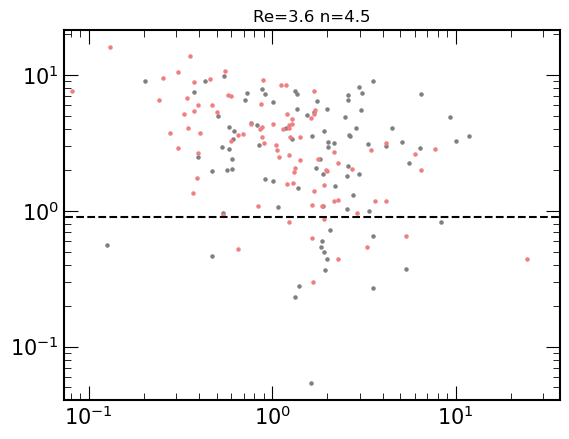

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.783359050750732
4.5 4.1
finished until t = 0.0 0.5964615345001221
finished until t = 0.5 5.161018133163452
finished until t = 1.0 13.79482913017273
finished until t = 1.5 26.447050094604492
finished until t = 2.0 43.2537579536438
finished until t = 2.5 64.15987467765808
finished until t = 3.0 89.40407848358154
finished until t = 3.5 118.45876884460449
finished until t = 4.0 151.35036516189575
finished until t = 4.5 188.19859886169434
finished until t = 5.0 228.78772044181824
finished until t = 5.5 273.54398107528687
finished until t = 6.0 321.76885890960693
finished until t = 6.5 373.8978588581085
finished until t = 7.0 429.9518029689789
finished until t = 7.5 491.0282452106476
finished until t = 8.0 555.7376747131348
finished until t = 8.5 624.0020229816437
finished until t = 9.0 694.1452026367188
finished until t = 9.5 757.6851527690887
finished until t = 10.0 824.5579335689545


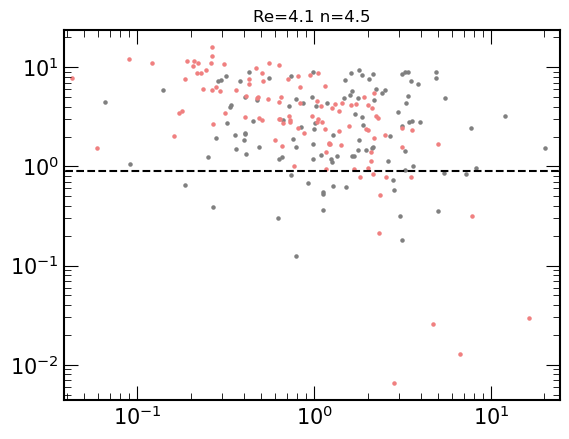

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
4.854398727416992
4.5 4.6
finished until t = 0.0 0.4667842388153076
finished until t = 0.5 3.679273843765259
finished until t = 1.0 9.474403858184814
finished until t = 1.5 18.06573796272278
finished until t = 2.0 29.526631116867065
finished until t = 2.5 43.98209047317505
finished until t = 3.0 61.31701159477234
finished until t = 3.5 81.50045347213745
finished until t = 4.0 104.57764410972595
finished until t = 4.5 130.06875824928284
finished until t = 5.0 158.2062520980835
finished until t = 5.5 189.23517298698425
finished until t = 6.0 224.17732167243958
finished until t = 6.5 261.31141781806946
finished until t = 7.0 300.9810607433319
finished until t = 7.5 343.5358786582947
finished until t = 8.0 386.71445083618164
finished until t = 8.5 432.3481240272522
finished until t = 9.0 480.4017083644867
finished until t = 9.5 531.0807838439941
finished until t = 10.0 585.1983482837677


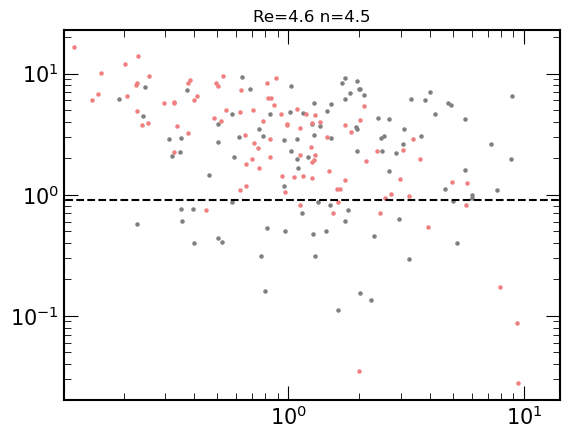

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
4.581291198730469
4.5 5.1
finished until t = 0.0 0.4317343235015869
finished until t = 0.5 3.26389479637146
finished until t = 1.0 8.56212329864502
finished until t = 1.5 16.17697787284851
finished until t = 2.0 26.208509922027588
finished until t = 2.5 38.78962802886963
finished until t = 3.0 54.09782314300537
finished until t = 3.5 73.03226804733276
finished until t = 4.0 94.5029833316803
finished until t = 4.5 116.9137315750122
finished until t = 5.0 141.75241422653198
finished until t = 5.5 169.1916925907135
finished until t = 6.0 199.07758140563965
finished until t = 6.5 231.68865299224854
finished until t = 7.0 266.95560479164124
finished until t = 7.5 305.10020112991333
finished until t = 8.0 347.30148243904114
finished until t = 8.5 392.1385371685028
finished until t = 9.0 439.3562047481537
finished until t = 9.5 488.10816287994385
finished until t = 10.0 539.2847390174866


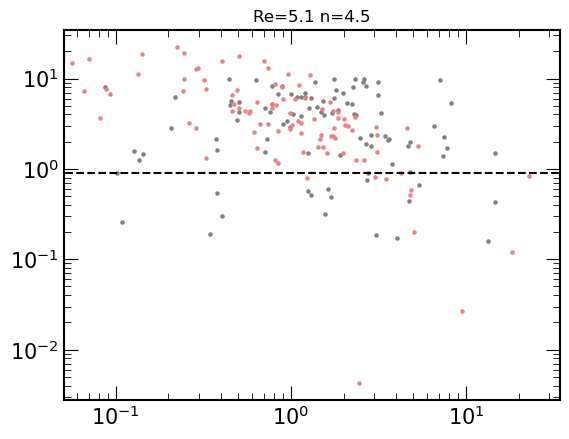

In [4]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [4.5]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [4]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
14.006537437438965
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
13.529197216033936


In [5]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [4.5]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [6]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 2.423234462738037
finished until t = 0.5 97.36126208305359
finished until t = 1.0 277.18950366973877
finished until t = 1.5 543.804194688797
finished until t = 2.0 898.0893437862396
finished until t = 2.5 1336.4039406776428
finished until t = 3.0 1858.761063337326
finished until t = 3.5 2464.7753987312317
finished until t = 4.0 3157.7846281528473
finished until t = 4.5 3934.613862991333
finished until t = 5.0 4801.583019256592
finished until t = 5.5 5744.182788610458
finished until t = 6.0 6772.258473396301
finished until t = 6.5 7881.4011607170105
finished until t = 7.0 9071.66804599762
finished until t = 7.5 10342.925194263458
finished until t = 8.0 11693.118809700012
finished until t = 8.5 13122.311103343964
finished until t = 9.0 14637.99776506424
finished until t = 9.5 16240.980098247528
finished until t = 10.0 17800.18051624298


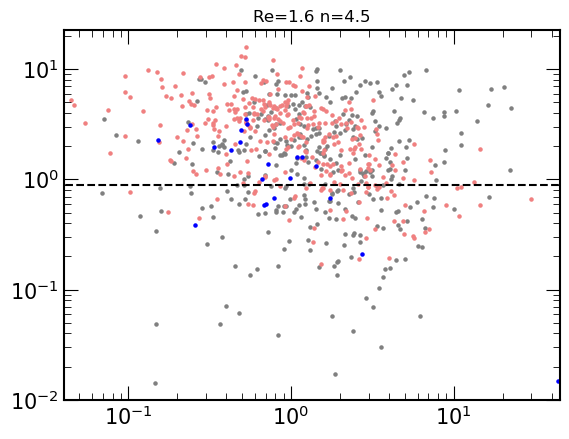

finished until t = 0.0 1.9062116146087646
finished until t = 0.5 88.88176274299622
finished until t = 1.0 259.87815833091736
finished until t = 1.5 514.1478297710419
finished until t = 2.0 850.3706424236298
finished until t = 2.5 1269.2730383872986
finished until t = 3.0 1769.172472000122
finished until t = 3.5 2349.2402019500732
finished until t = 4.0 3010.2043092250824
finished until t = 4.5 3751.6889083385468
finished until t = 5.0 4573.601833581924
finished until t = 5.5 5474.475355148315
finished until t = 6.0 6453.040111064911
finished until t = 6.5 7513.049718618393
finished until t = 7.0 8653.047949552536
finished until t = 7.5 9871.471956253052
finished until t = 8.0 11168.48042178154
finished until t = 8.5 12544.505859613419
finished until t = 9.0 13967.962591409683
finished until t = 9.5 15164.969501972198
finished until t = 10.0 16364.122187376022


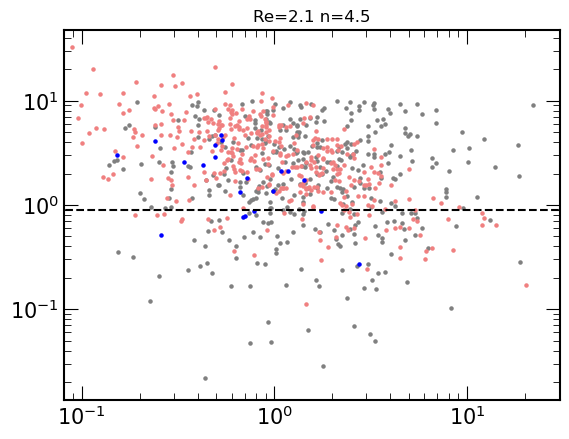

In [7]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 1.586057186126709
finished until t = 0.5 17.52437162399292


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 1.0 48.53449487686157
finished until t = 1.5 92.222909450531
finished until t = 2.0 147.96191811561584
finished until t = 2.5 215.38384819030762
finished until t = 3.0 293.7379398345947
finished until t = 3.5 384.99452543258667
finished until t = 4.0 486.21517395973206
finished until t = 4.5 598.9648258686066
finished until t = 5.0 723.6977913379669
finished until t = 5.5 858.2712352275848
finished until t = 6.0 1001.7755987644196
finished until t = 6.5 1153.377788066864
finished until t = 7.0 1313.9574875831604
finished until t = 7.5 1483.9405558109283
finished until t = 8.0 1662.1585202217102
finished until t = 8.5 1850.0146315097809
finished until t = 9.0 2047.4230298995972
finished until t = 9.5 2259.0123653411865
finished until t = 10.0 2476.375258922577


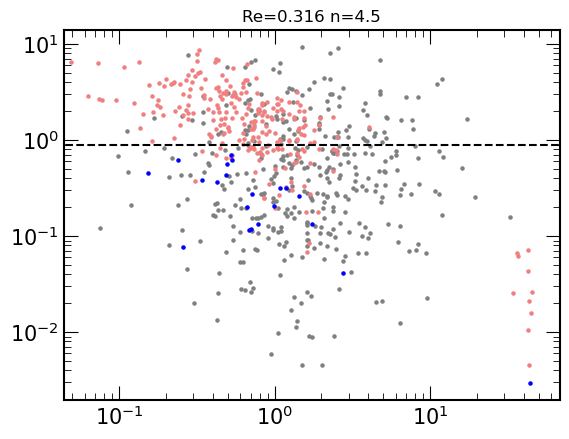

In [6]:
#NFW
R_e_values = [0.316]
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
 

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
           